# Генератор лиц

In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):
        """
        image_size -- размер стороны квадратной картинки
        output_path -- путь для сохранения артефактов обучения. в корне -- картинки с разных итераций, в папке model -- модель
        num_channels -- количество каналов изображения
        z_dim -- размерность латентного вектора
        G_h_size -- минимальный размер фильтров с сверточных слоях генератора
        D_h_size -- минимальный размер фильтров с сверточных слоях дискриминатора
        """
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) # столько раз нужно применить апсемплинг или даунсемплинг
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2) и наоборот
                                                
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Функция содержит Conv + BatchNorm + LeakyReLU
        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в 
        картинку image_size x image_size x num_channels

        """
        
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 2**self.multiply)
        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1))) # уменьшаем количество фильтров в два раза
        
        assert model.output_shape[1:] == (self.image_size // 2, self.image_size // 2, self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):
        """
        Цикл обучения
        """
        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return
        


## Загрузка датасета

In [ ]:
! pip install gdown
import gdown

In [ ]:
url = '...'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

## Создание генераторов данных

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 32

In [ ]:
import os
os.listdir("/tmp/UTKFace/")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: "/tmp/UTKFace/" + x.name, data_folder.glob('*.jpg')))

data = pd.DataFrame(filenames, columns=["img_name"])    

def preprocess_image(image):
    return np.interp(image, (0, 255), (-1.0, 1))

image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    data,
    x_col="img_name",
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE, 
    class_mode=None, 
    shuffle=True
    )

Found 23708 validated image filenames.


## Обучение DCGAN

In [ ]:
output = Path("/gan_model")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=100, D_h_size=128, G_h_size=128)

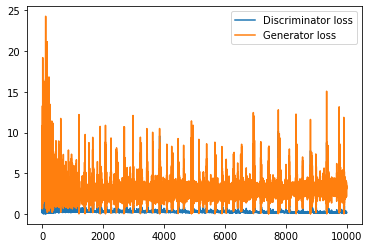

<Figure size 432x288 with 0 Axes>

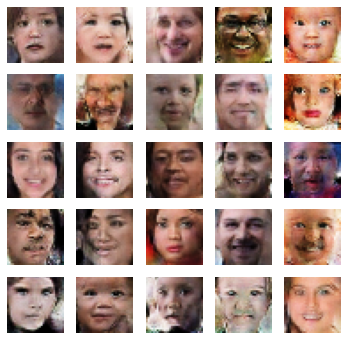


10000/10000
Time elapsed from start 4445.963287591934 sec
Finished. Time elapsed from start 4445.963335037231 sec


In [ ]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

Лица, которые модель научилась генерировать

In [ ]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [-0.30052036  0.10767423 -1.0458273  -0.24463262  0.8513772   0.71822876
 -1.0084084   0.54647875 -0.78505796 -0.91560477]


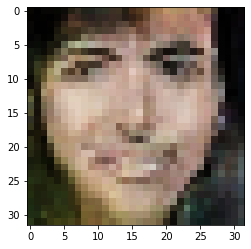

In [ ]:
v1 = tf.random.normal([1, 100]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0]) # сгенерированное лицо

## Поиск вектора улыбки

Модель научилась из 100 чисел генерировать лица, среди которых есть улыбающиеся и нейтральные. Тогда можно считать, что есть определенная комбинация этих 100 чисел, прибавив которую к вектору соответствующему нейтральному лицу можно получить это же лицо, только с улыбкой. Эти 100 чисел мы и называем “вектор улыбки”. 


In [ ]:
def generate_many(generator, n):
    vis_noise = np.random.normal(0, 1, (n, 100)).astype(np.float32)
    gen_imgs = generator(vis_noise, training=False)
    show_many(gen_imgs, "Generated images")
    return vis_noise

def show_many(images, title=""):
    w = h = int(np.sqrt(len(images)))
    images = (np.clip(images, -1, 1) + 1.) / 2. 
    
    fig, axs = plt.subplots(w, h, figsize=(w, h))
    if title != "":
        fig.suptitle(title)

    cnt = 0
    for i in range(h):
        for j in range(w):
            axs[i, j].imshow(images[cnt, :, :, :])
            axs[i, j].set_title(f"{cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=.5)
    

### Интерполяция

In [ ]:
def show_interpolation(v_1, v_2, generator=gan.generator, n=20):
    """
    Превращает v_1 в v_2 за n шагов, изображая 
    картинки соответствующие промежуточным векторам
    Функция отображает превращение лица вектора v_1 в лицо вектора v_2

    """
    fig, axs = plt.subplots(1, n, figsize=(n,1))
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        curr_vec = v_1 * (1-alpha) + v_2 * alpha
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

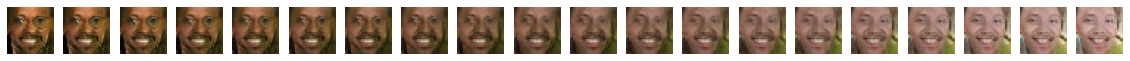

In [ ]:
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

show_interpolation(v1, v2)

## Поиск вектора улыбки

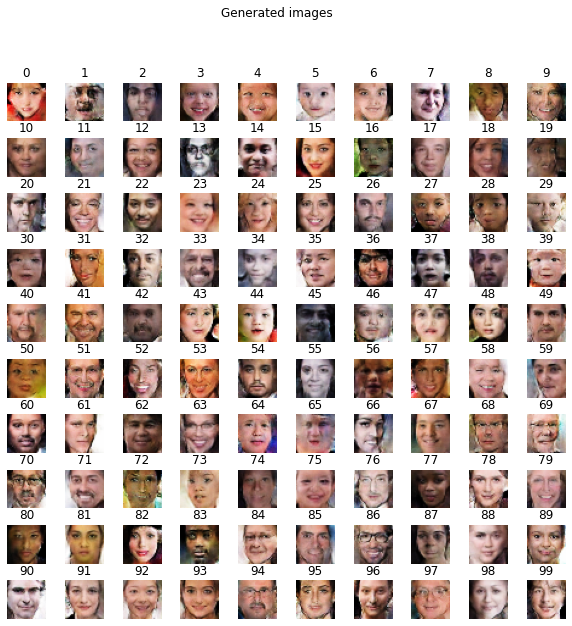

In [ ]:
faces = generate_many(gan.generator, n=100)

In [ ]:
# средний "улыбающийся" вектор
mean_smile_face = np.zeros(100)
list_smile_fases_nums = [3,4,12,18,21,23,25,33,51,52,63,66,71,79,86]
for i in list_smile_fases_nums:
    mean_smile_face += faces[i]
mean_smile_face /= len(list_smile_fases_nums)

In [ ]:
# средний "нейтральный" вектор
mean_neutral_face = np.zeros(100)
list_neutral_fases_nums = [2,5,10,13,20,22,32,38,47,48,49,68,94,70,61]
for i in list_neutral_fases_nums:
    mean_neutral_face += faces[i]
mean_neutral_face /= len(list_neutral_fases_nums)

In [ ]:
# вектор улыбки
smile_vector = mean_smile_face - mean_neutral_face
smile_vector

array([-0.1597982 , -0.17978294,  0.38600509,  0.35538257, -0.36094354,
        0.11046142,  0.16930325,  0.53241299, -0.60986059,  0.03380225,
       -0.8790101 ,  0.42645576,  0.52838889,  0.03080266, -0.0916137 ,
        0.56236589,  0.08191042,  0.52567843,  0.06195926,  0.16916186,
        0.64150952,  0.57164607,  0.20719831, -0.18230659, -0.30784228,
       -0.09206945,  0.30952036, -0.2232242 , -0.01617638, -0.18745926,
       -0.68097369, -0.63471042, -0.1436709 ,  0.08802033, -0.14418597,
        0.37307568,  0.14127014,  0.34442913, -0.02719488,  0.44302882,
        0.04416211, -0.57721881,  0.05431942, -0.10374654, -0.47263134,
       -0.09715468, -0.46905211, -0.82073204, -0.68179266,  0.45158654,
       -0.60584037,  0.43679962, -0.02899938,  0.22286614, -0.32233915,
       -0.51380971,  0.56261289, -0.45225665,  0.56620289,  0.70643547,
        0.31180537,  0.29942688, -0.08488934,  0.43401631,  0.28908012,
       -0.76687615,  0.06740407, -0.1794184 ,  0.6255946 , -0.38

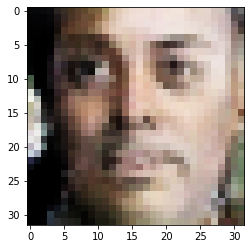

In [ ]:
# Нейтральный (исходный)
_ = plt.imshow(generate_data(np.array([faces[32]]), gan.generator)[0])

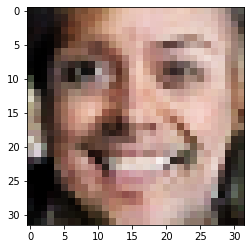

In [ ]:
# Улыбающийся (после прибавления вектора улыбки)
_ = plt.imshow(generate_data(np.array([faces[32] + smile_vector]), gan.generator)[0])

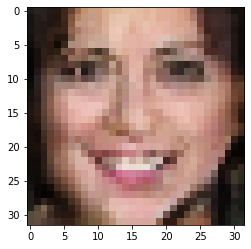

In [ ]:
# Улыбающийся (исходный)
_ = plt.imshow(generate_data(np.array([faces[25]]), gan.generator)[0])

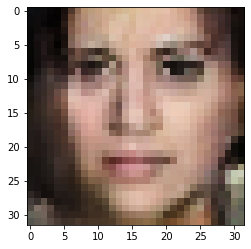

In [ ]:
# Нейтральный (после вычета вектора улыбки)
_ = plt.imshow(generate_data(np.array([faces[25] - smile_vector]), gan.generator)[0])